# Chapter 8: Dimensionality Reduction

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_openml
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.manifold import TSNE, LocallyLinearEmbedding, MDS
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import MinMaxScaler

1. Having 1,000s of features makes training very slow and makes finding a good solution very difficult due to the curse of dimensionality. One solution is to reduce the number of features, however this does result in some information loss. Dimensionality reduction techniques can also be used for visualization and compression. Additional drawbacks are computational costs, complexity, and less interpretable features.
2. **The Curse of Dimensionality.** "high-dimensional datasets are at risk of being very sparse: most training instances are likely to be far away from each other. This also means that a new instance will likely be far away from any training instance, making predictions much less reliable than in lower dimensions, since they will be based on much larger extrapolations." **This cannot be resolved, practically, by increasing the training set size**: "With just 100 ... ranging from 0 to 1, you would need more training instances than atoms in the observable universe in order for training instances to be within 0.1 of each other on average..."
3. Some dimensionality reduction techniques come with an inverse transformation, although this is not a perfect inverse and some information is always lost.
4. PCA will still get rid of useless dimensions even if the dataset is nonlinear.
5. It depends on the dataset. Suppose all features are constant except one, then all the other features will be dropped while maintaining all the variance. For example:

In [2]:
X = np.random.randn(100, 1_000)

pca = PCA(n_components=0.95)
print(pca.fit_transform(X).shape[-1])


X = np.random.randn(8000, 1_000)

pca = PCA(n_components=0.95)
print(pca.fit_transform(X).shape[-1])


X = np.hstack([np.random.randn(100, 1), np.ones((100, 999))])

pca = PCA(n_components=0.95)
print(pca.fit_transform(X).shape[-1])

90
900
1


6. Different types of Projections:
    * **Regular PCA**: Good for when the dataset fits in memory.
    * **Incremental PCA**: This is good for out of core or online learning. But is slower than regular PCA.
    * **Randomized PCA**: Finds an approximation of the first $d$-components. It is much faster the full SVD decomposition used in regular PCA. It has a computational complexity of $O(m \times d^3) + O(d^3)$ instead of $O(m \times n^3) + O(n^3)$. It is ideal when the dataset is very large & $d<<n$.
    * **Random Projections**: Useful for when your dataset is really big and even randomized PCA is too slow.
7. If the dimensionality reduction algorithm has a reverse transformation then you can use reconstruction error to evaluate it. However, if not you can use the downstream model performance.
8. Yes. You can use a projection method first to get rid of many useless dimensions to speed up a subsequent manifold learning technique.

## 9. PCA to speed up a random forest on MNIST 

In [3]:
mnist = fetch_openml("mnist_784", as_frame=False, parser="auto")
X, y = mnist.data, mnist.target
X_train, X_test, y_train, y_test = X[:60_000], X[60_000:], y[:60_000], y[60_000:]

In [4]:
random_forest = RandomForestClassifier(n_jobs=-1)
sgd_classifier = SGDClassifier(n_jobs=-1)

pca = PCA(n_components=0.95)
X_train_reduced = pca.fit_transform(X_train)
X_test_reduced = pca.transform(X_test)

In [5]:
%time random_forest.fit(X_train, y_train)
random_forest.score(X_test, y_test)

CPU times: user 1min 8s, sys: 583 ms, total: 1min 8s
Wall time: 9.81 s


0.9697

In [6]:
%time random_forest.fit(X_train_reduced, y_train)
random_forest.score(X_test_reduced, y_test)

CPU times: user 3min 17s, sys: 989 ms, total: 3min 18s
Wall time: 27.2 s


0.9484

In [7]:
%time sgd_classifier.fit(X_train, y_train)
sgd_classifier.score(X_test, y_test)

CPU times: user 4min 12s, sys: 1.81 s, total: 4min 14s
Wall time: 47.4 s


0.8752

In [8]:
%time sgd_classifier.fit(X_train_reduced, y_train)
sgd_classifier.score(X_test_reduced, y_test)

CPU times: user 42.3 s, sys: 279 ms, total: 42.6 s
Wall time: 8.23 s


0.8928

PCA really helped out for the SGD classifier, but hurt the performance of the random forrest.

## 10. Dimensionality reduction for data visualization

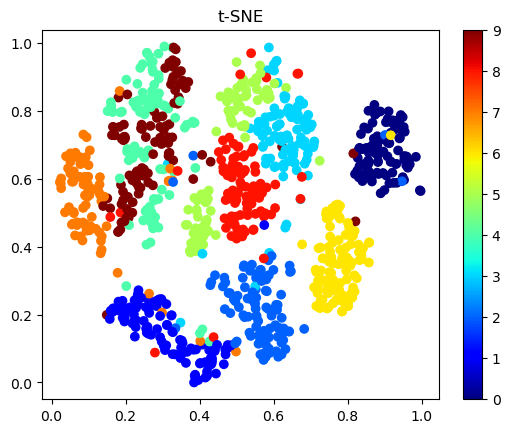

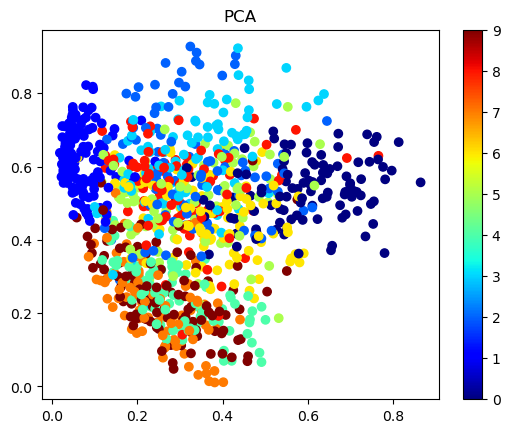

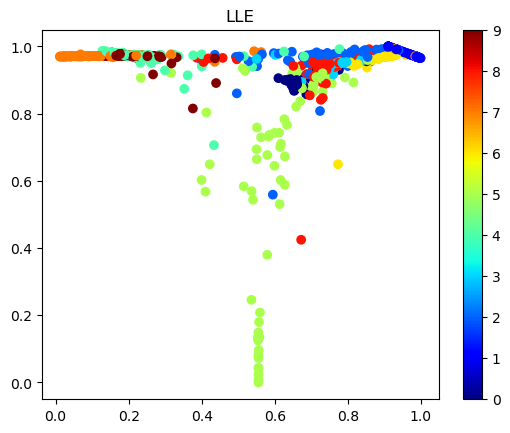

/opt/miniconda3/envs/homl3/lib/python3.10/site-packages/sklearn/manifold/_mds.py:298: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


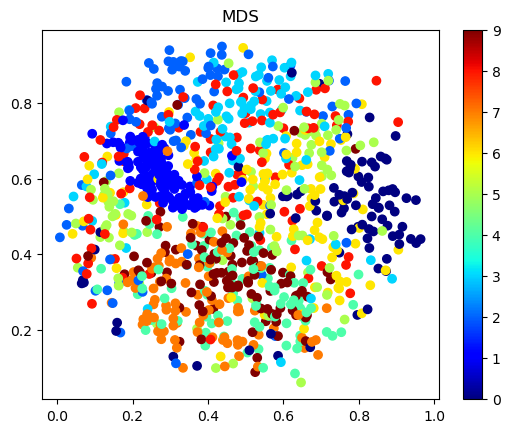

In [9]:
n_samples = 5_000
plot_n = 1_000


def plot_digits(X_2d, y_2d, title=None):
    indices = np.random.choice(n_samples, plot_n, replace=False)
    plt.scatter(
        X_2d[indices, 0],
        X_2d[indices, 1],
        c=y_2d[indices].astype(int),
        cmap="jet",
    )
    plt.colorbar()
    plt.title(title)
    plt.show()


indices = np.random.choice(X.shape[0], n_samples, replace=False)
y_2d = y[indices]

tsne = make_pipeline(
    PCA(n_components=50, svd_solver="randomized"),
    TSNE(n_components=2, init="random", n_jobs=-1),
)
X_2d = MinMaxScaler().fit_transform(tsne.fit_transform(X[indices]))
plot_digits(X_2d, y_2d, "t-SNE")

pca = make_pipeline(PCA(n_components=2), MinMaxScaler())
X_2d = pca.fit_transform(X[indices])
plot_digits(X_2d, y_2d, "PCA")

lle = make_pipeline(LocallyLinearEmbedding(n_components=2), MinMaxScaler())
X_2d = lle.fit_transform(X[indices])
plot_digits(X_2d, y_2d, "LLE")

mds = MDS(n_components=2, n_jobs=-1)
X_2d = MinMaxScaler().fit_transform(mds.fit_transform(X[indices]))
plot_digits(X_2d, y_2d, "MDS")